In [204]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Image transformation

In [206]:
train_transform = transforms.Compose([
    #transforms.Resize((320, 320)),
    transforms.Resize(384),
    transforms.CenterCrop(320),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    #transforms.Resize((320, 320)),
    transforms.Resize(384),
    transforms.CenterCrop(320),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


### load dataset

In [208]:
data_dir = "/Users/vijani/Documents/hoogschool/block B/projects/individual project/dataset"

full_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=val_test_transform  # temporary, will override for train
)

class_names = full_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)


Classes: ['keeri samba', 'rathu kekulu', 'samba', 'suwandel']


#### Define split sizes

In [210]:
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size


#### Random split

In [212]:
torch.manual_seed(42)

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)


#### correct transforms

In [214]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform


#### create data loaders

In [216]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


#### verify split balance

In [218]:
def count_labels(subset):
    labels = [full_dataset.targets[i] for i in subset.indices]
    return Counter(labels)

print("Train:", count_labels(train_dataset))
print("Val:", count_labels(val_dataset))
print("Test:", count_labels(test_dataset))


Train: Counter({1: 47, 2: 45, 3: 43, 0: 35})
Val: Counter({3: 11, 0: 10, 2: 9, 1: 6})
Test: Counter({0: 15, 3: 9, 1: 7, 2: 6})


### Model: Transfer Learning (MobileNetV2)

In [220]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(pretrained=True)

# Freeze backbone
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier
model.classifier[1] = nn.Linear(
    model.last_channel,
    num_classes
)

model = model.to(device)


/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Loss function and optimizer

In [222]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.classifier.parameters(),
    lr=0.001
)

### Training loop

In [224]:
def train_model(model, train_loader, val_loader, epochs=15):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


### Train model

In [226]:
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, epochs=20
)

Epoch [1/20] Train Loss: 1.3111, Train Acc: 0.3294 | Val Loss: 1.3446, Val Acc: 0.5556
Epoch [2/20] Train Loss: 0.6807, Train Acc: 0.9294 | Val Loss: 0.7481, Val Acc: 0.9167
Epoch [3/20] Train Loss: 0.3959, Train Acc: 0.9706 | Val Loss: 0.4302, Val Acc: 0.9722
Epoch [4/20] Train Loss: 0.2670, Train Acc: 0.9706 | Val Loss: 0.2985, Val Acc: 0.9722
Epoch [5/20] Train Loss: 0.1984, Train Acc: 0.9941 | Val Loss: 0.1598, Val Acc: 0.9722
Epoch [6/20] Train Loss: 0.1743, Train Acc: 0.9824 | Val Loss: 0.1102, Val Acc: 1.0000
Epoch [7/20] Train Loss: 0.1335, Train Acc: 0.9882 | Val Loss: 0.0906, Val Acc: 1.0000
Epoch [8/20] Train Loss: 0.1423, Train Acc: 0.9941 | Val Loss: 0.0780, Val Acc: 1.0000
Epoch [9/20] Train Loss: 0.1395, Train Acc: 0.9882 | Val Loss: 0.0739, Val Acc: 0.9722
Epoch [10/20] Train Loss: 0.0782, Train Acc: 0.9941 | Val Loss: 0.0546, Val Acc: 1.0000
Epoch [11/20] Train Loss: 0.0617, Train Acc: 1.0000 | Val Loss: 0.0473, Val Acc: 1.0000
Epoch [12/20] Train Loss: 0.0730, Train A

### Plot Loss + Accuracy in ONE FIGURE

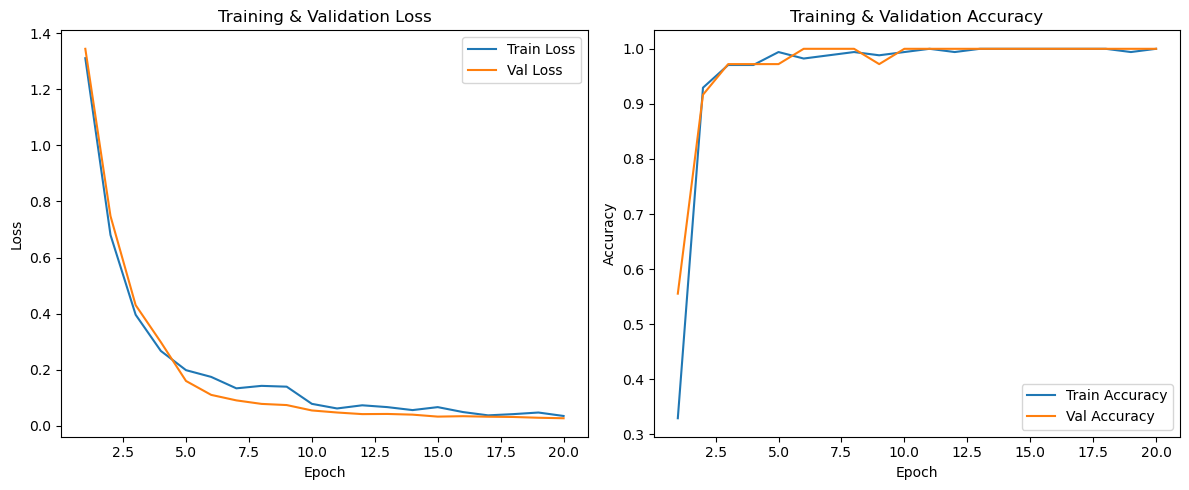

In [228]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


### Fine-Tuning

In [230]:
'''
for param in model.features[-2:].parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_model(model, train_loader, val_loader, epochs=5)
'''

'\nfor param in model.features[-2:].parameters():\n    param.requires_grad = True\n\noptimizer = optim.Adam(model.parameters(), lr=1e-4)\n\ntrain_model(model, train_loader, val_loader, epochs=5)\n'

### Evaluation on test set (Accuracy)

In [232]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")

    return y_true, y_pred


In [233]:
y_true, y_pred = evaluate_model(model, test_loader)


Test Accuracy: 1.0000


### Confusion matrix

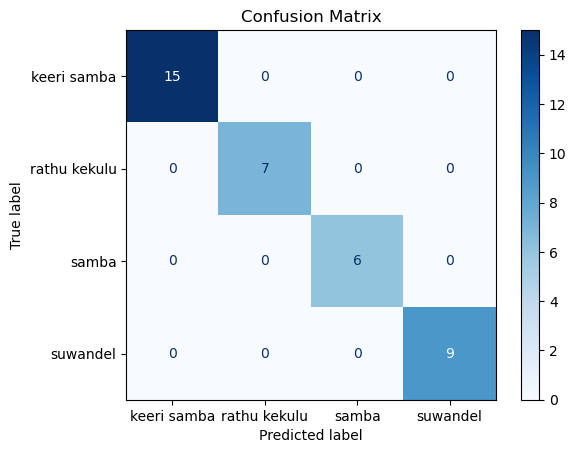

In [235]:


cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


### Save the model

In [256]:
torch.save(model.state_dict(), "rice_classifier.pth")